光束大小已修改为: 200μm x 200μm
探测器已更新为 Mercu 1717V 参数:
  像素尺寸: 139.0μm x 139.0μm
  像素矩阵: 3072 x 3072
  物理尺寸: 427.0mm x 427.0mm
样品直径已修改为: 2000.0μm (即 2mm)
样品材料: 镍 (Nickel), 结构信息从 Ni.cif 加载
基准取向已设定: 晶体 [1 1 0] 方向 || 光束 [1 0 0] 方向
为样品添加最大为 3.0° 的随机取向扩展...
已为所有 46 个单元生成了目标取向的晶粒。
Rendering 11021 scattering volumes unto the detector    |████████████████████████████████████████| 100.0%


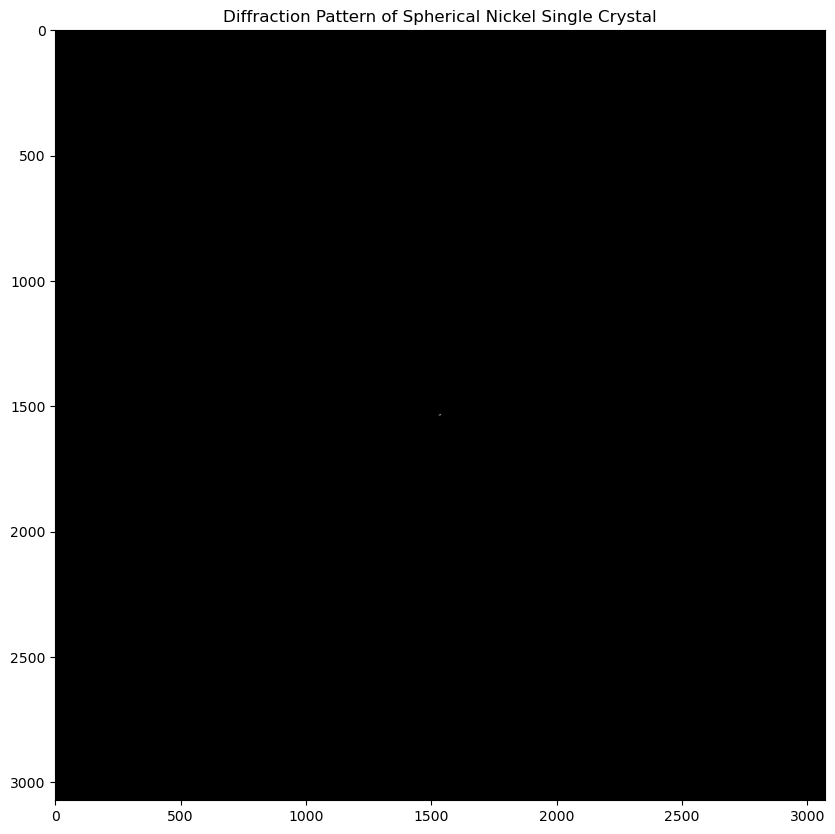

In [ ]:
import numpy as np
from xrd_simulator.beam import Beam
from xrd_simulator.detector import Detector
from xrd_simulator.mesh import TetraMesh
from xrd_simulator.phase import Phase
from xrd_simulator.polycrystal import Polycrystal
from xrd_simulator.motion import RigidBodyMotion
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# --- 光束定义 (修改) ---
beam = Beam(
    np.array([
        [-1e6, -100., -100.], [-1e6, 100., -100.], [-1e6, 100., 100.], [-1e6, -100., 100.],
        [1e6, -100., -100.], [1e6, 100., -100.], [1e6, 100., 100.], [1e6, -100., 100.]
    ]),
    xray_propagation_direction=np.array([1., 0., 0.]),
    wavelength=0.1258,
    polarization_vector=np.array([0., 1., 0.])
)
print("光束大小已修改为: 200μm x 200μm")

detector_distance = 1324.9
detector_distance = 300
pixel_size_um = 139.0
number_of_pixels = 3072

# 计算探测器的总物理尺寸 (单位: μm)
detector_size_um = number_of_pixels * pixel_size_um
half_detector_size = detector_size_um / 2.0

# 创建新的探测器对象
detector = Detector(
    pixel_size_z=pixel_size_um,
    pixel_size_y=pixel_size_um,
    det_corner_0=np.array([detector_distance, -half_detector_size, -half_detector_size]),
    det_corner_1=np.array([detector_distance,  half_detector_size, -half_detector_size]),
    det_corner_2=np.array([detector_distance, -half_detector_size,  half_detector_size])
)

print(f"探测器已更新为 Mercu 1717V 参数:")
print(f"  像素尺寸: {pixel_size_um}μm x {pixel_size_um}μm")
print(f"  像素矩阵: {number_of_pixels} x {number_of_pixels}")
print(f"  物理尺寸: {detector_size_um/1000:.1f}mm x {detector_size_um/1000:.1f}mm")

# --- 几何形状定义 (修改) ---
new_radius = 1000.0 # 2mm直径 = 2000μm直径 = 1000μm半径
mesh = TetraMesh.generate_mesh_from_levelset(
    level_set=lambda x: np.linalg.norm(x) - new_radius,
    bounding_radius=new_radius + 1.0,  # 边界半径略大于样品半径
    max_cell_circumradius=600.) # 也可以按比例调整网格尺寸
print(f"样品直径已修改为: {2*new_radius}μm (即 2mm)")

# --- 2. 定义镍(Ni)的晶体属性 (最终修正) ---
# Define the basic parameters, as required by the class
nickel_unit_cell = [3.52, 3.52, 3.52, 90., 90., 90.]
nickel_sgname = 'Fm-3m'

# Provide ALL required arguments to the Phase class
nickel_phase = Phase(
    unit_cell=nickel_unit_cell,
    sgname=nickel_sgname,
    path_to_cif_file='Ni.cif'  # Or 'Nickel.cif', whichever you named it
)

print(f"样品材料: 镍 (Nickel), 结构信息从 {nickel_phase.path_to_cif_file} 加载")

# --- 3. 定义特定取向的近单晶 (修改为[110]入射) ---

# A. 计算基准取向: 让晶体的[110]方向对准光束
crystal_direction_to_align = np.array([1, 1, 0])
beam_direction_in_lab = np.array([1, 0, 0]) # 光束传播方向
base_rotation_object, _ = R.align_vectors([beam_direction_in_lab], [crystal_direction_to_align])
print(f"基准取向已设定: 晶体 {crystal_direction_to_align} 方向 || 光束 {beam_direction_in_lab} 方向")

# B. 在新的基准取向上添加3°的随机取向扩展 (此部分逻辑完全不变)
max_misorientation_degrees = 3.0
max_misorientation_radians = np.radians(max_misorientation_degrees)
orientations_with_spread = []

print(f"为样品添加最大为 {max_misorientation_degrees}° 的随机取向扩展...")
for _ in range(mesh.number_of_elements):
    # 生成一个微小的随机旋转
    random_axis = np.random.randn(3)
    if np.linalg.norm(random_axis) > 1e-8:
        random_axis /= np.linalg.norm(random_axis)
    random_angle = np.random.rand() * max_misorientation_radians
    small_random_rotation = R.from_rotvec(random_angle * random_axis)

    # 最终取向 = 小的随机旋转 * 基准旋转
    final_rotation = small_random_rotation * base_rotation_object
    
    orientations_with_spread.append(final_rotation.as_matrix())

# 将取向列表转换为numpy数组，以供模拟器使用
single_crystal_orientation = np.array(orientations_with_spread)
print(f"已为所有 {mesh.number_of_elements} 个单元生成了目标取向的晶粒。")

# --- 4. 组装成单晶样品 (修改) ---
polycrystal = Polycrystal(
    mesh=mesh,
    orientation=single_crystal_orientation,
    strain=np.zeros((3, 3)),
    phases=[nickel_phase], # <-- 将单个对象放入列表中
    element_phase_map=None
)

# --- 5. 执行模拟和渲染 (保持不变) ---
motion = RigidBodyMotion(
    rotation_axis=np.array([0, 1/np.sqrt(2), -1/np.sqrt(2)]),
    rotation_angle=np.radians(1.0),
    translation=np.array([0., 0., 0.])  # <-- 补上必需的 translation 参数
)
polycrystal.diffract(beam, detector, motion)
diffraction_pattern = detector.render(frames_to_render=0)

# --- 6. 显示结果 ---
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(diffraction_pattern, cmap='gray')
ax.set_title("Diffraction Pattern of Spherical Nickel Single Crystal")
plt.show()

In [9]:
# 保存晶体模型，便于后续使用或可视化
polycrystal.save('Nickel_crystal', save_mesh_as_xdmf=True)  # 保存为xdmf格式，可在ParaView等软件中查看